In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
from sklearn.model_selection import train_test_split
np.random.seed(42)
import scipy.stats as stats
import seaborn as sns
from datetime import timedelta  

from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

plt.style.use(["presentation"])

%matplotlib inline

In [2]:
prediction_data=pd.read_csv('./assets/test.csv')

In [3]:
working_data=pd.read_csv('./assets/train.csv')

In [4]:
NOAA=pd.read_csv('./assets/weather.csv')

In [5]:
spray=pd.read_csv('./assets/spray.csv')

In [6]:
standing=pd.read_csv('./extra_data/Sanitation_Revised.csv')

# A. Data QA/Cleaning

In [7]:
# Train-test split
train, test=train_test_split(working_data, test_size=.20, random_state=523)

In [8]:
# Only two species carry west nile virus

train.groupby(by='Species')['WnvPresent'].mean()

Species
CULEX PIPIENS             0.085952
CULEX PIPIENS/RESTUANS    0.054068
CULEX RESTUANS            0.016988
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

In [9]:
# Copy the train and test datafarmes so that I don't get annoying error messages about
# altering dataframe slices

train=train.copy()
test=test.copy()

In [10]:
# Make dummies, and convert lat/lon to a single tuple.  Drop fields we don't need.

def clean(df):
    df['Date']=pd.to_datetime(df['Date'])
    
    def mapping(x):
        if x == 'CULEX PIPIENS':
            return 'PIPIENS'
        elif x == 'CULEX PIPIENS/RESTUANS':
            return 'MIX'
        elif x == 'CULEX RESTUANS':
            return 'RESTUANS'
        else:
            return 'OTHER'
    
    df['Species']=df['Species'].map(mapping)
    
    dummies=pd.get_dummies(df['Species']).drop(['OTHER'], axis=1)
    df=pd.concat([df, dummies], axis=1)
    df['Location']=list(zip(df['Latitude'],df['Longitude']))
    df=df.drop(['Address', 'Latitude', 'Longitude', 'Trap', 
                'AddressNumberAndStreet', 'AddressAccuracy','Species'], axis=1)
                    
    return df

In [11]:
# Apply pre-processing

train=clean(train)
test=clean(test)
prediction_data=clean(prediction_data)

In [12]:
# Some pre-processing of the standing water data

standing['Coord']=list(zip(standing['Latitude'], standing['Longitude']))

In [13]:
standing=standing['Coord'].dropna()

# A. Get recent weather data

In [10]:
# Convert the dates to datetime format
NOAA['Date'] = pd.to_datetime(NOAA['Date'])

In [11]:
# Get rid of all station 2 input
NOAA = NOAA[NOAA['Station'] == 1]

In [12]:
#changing the values 'M' values to the straight average in 'Tavg'
new_vals = []

for i, x in enumerate(NOAA['Tavg']):
    if x == 'M':
        avg = (NOAA['Tmax'].loc[i] + NOAA['Tmin'].loc[i]) / 2
        new_vals.append(avg)
    else:
        new_vals.append(x)
        
NOAA['Tavg'] = new_vals
NOAA['Tavg'] = NOAA['Tavg'].astype(int)

In [13]:
#Changing the 'T' for trace rain to a quantity of 0.001, forward filling 'M' values
NOAA['PrecipTotal'] = NOAA['PrecipTotal'].apply(lambda x: 0.001 if x == '  T' 
                                                      else x).replace('M', np.nan).fillna(method='ffill').astype(float)


In [15]:
NOAA.to_pickle('./assets/NOAA')

In [20]:
# The complete life cycle of mosquitos is ~ 14 days.

# SOURCE = https://biocyclopedia.com/index/biotechnology_methods/cell_biology_and_genetics/life_cycle_of_the_mosquito_culex_pipiens.php

In [21]:
def measure_recent_temps(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=14)))&(NOAA['Date']<=A)]['Tavg'].mean()

In [22]:
def min_recent_temps(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=14)))&(NOAA['Date']<=A)]['Tavg'].min()

In [23]:
def measure_recent_precip(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=14)))&(NOAA['Date']<=A)]['PrecipTotal'].sum()

In [24]:
train['recent_temps']=train['Date'].map(measure_recent_temps)
train['min_recent_temps']=train['Date'].map(min_recent_temps)

In [25]:
test['recent_temps']=test['Date'].map(measure_recent_temps)
test['min_recent_temps']=test['Date'].map(min_recent_temps)

In [26]:
prediction_data['recent_temps']=prediction_data['Date'].map(measure_recent_temps)
prediction_data['min_recent_temps']=prediction_data['Date'].map(min_recent_temps)

In [27]:
train['recent_precip']=train['Date'].map(measure_recent_precip)


In [28]:
test['recent_precip']=test['Date'].map(measure_recent_precip)

In [29]:
prediction_data['recent_precip']=prediction_data['Date'].map(measure_recent_precip)

# B. Get distance to the nearest location where standing water complaint ever filed

In [30]:
def measure_to_standing(input_location):
    distances=[]
    for standing_spot_location in standing:
        standing_spot_distance=haversine(standing_spot_location, input_location)
        distances+=[standing_spot_distance]
    return min(distances)
        

train['dist_to_standing_water']=train['Location'].map(measure_to_standing)


                                                      

In [31]:
test['dist_to_standing_water']=test['Location'].map(measure_to_standing)


In [32]:
prediction_data['dist_to_standing_water']=prediction_data['Location'].map(measure_to_standing)


# C. Measure distance to nearest place where pesticide was sprayed in 2011 or 2013 (assuming these are customary spray sites).

In [97]:
# Rounding off the latititudes and longitudes to aid in de-duplicating

spray['Latitude']=round(spray['Latitude'],3)
spray['Longitude']=round(spray['Longitude'],3)

In [98]:
# Convert the coordinates to a single tuple

spray['Coord']=list(zip(spray['Latitude'], spray['Longitude']))
spray=spray.dropna()

In [99]:
# Drop duplicates
spray=spray.drop_duplicates(['Coord'])

In [100]:
# Take a random sample to speed up calculation

spray=spray.sample(2000)

In [101]:
spray=spray['Coord']

In [102]:
def measure_to_spray(input_location):
    distances=[]
    for spray_spot_location in spray:
        spray_spot_distance=haversine(spray_spot_location, input_location)
        distances+=[spray_spot_distance]
    return min(distances)

In [103]:
train['dist_to_spray']=train['Location'].map(measure_to_spray)

In [104]:
test['dist_to_spray']=test['Location'].map(measure_to_spray)

In [105]:
prediction_data['dist_to_spray']=prediction_data['Location'].map(measure_to_spray)

In [115]:


train.to_pickle('./assets/train_step1')
test.to_pickle('./assets/test_step1')
prediction_data.to_pickle('./assets/prediction_step1')

# D. Check out the distributions of our key metrics

In [116]:
train.head()

,Date,Block,Street,NumMosquitos,WnvPresent,MIX,PIPIENS,RESTUANS,Location,recent_temps,min_recent_temps,recent_precip,dist_to_standing_water,dist_to_spray
4526,2009-07-06,50,S UNION AVE,4,0,1,0,0,"(41.803422999999995, -87.642984)",72.785714,61,0.592,0.204493,4.774018
2076,2007-08-16,12,S DOTY AVE,50,1,0,1,0,"(41.673408, -87.599862)",77.214286,71,4.070,1.499085,4.632153
3574,2007-09-24,58,N PULASKI RD,1,0,0,0,0,"(41.984809000000006, -87.728492)",65.500000,50,0.001,1.040195,1.873140
3427,2007-09-24,22,W 89TH ST,50,0,0,1,0,"(41.731922, -87.677512)",65.500000,50,0.001,1.110843,0.571260
3932,2009-06-02,35,W 51ST ST,3,0,1,0,0,"(41.800737, -87.71188000000001)",63.285714,54,2.352,0.303958,1.641308


/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


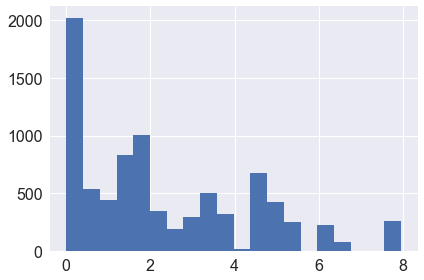

In [111]:
train['dist_to_spray'].hist(bins=20)

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


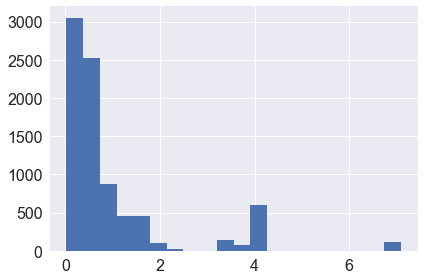

In [114]:
train['dist_to_standing_water'].hist(bins=20)

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


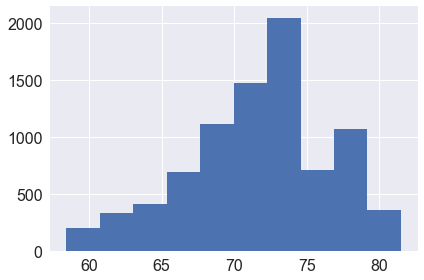

In [118]:
train['recent_temps'].hist(bins=10)

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


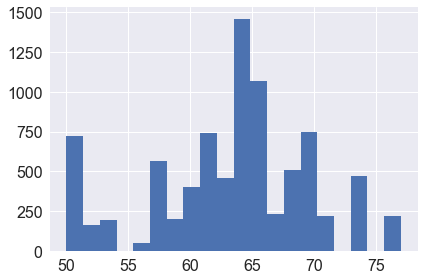

In [119]:
train['min_recent_temps'].hist(bins=20)

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


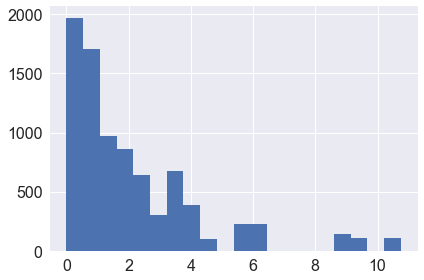

In [121]:
train['recent_precip'].hist(bins=20)

# E. Make some sort of reasonable dummy variables for street. 

In [148]:
# Aggregate training data by street and look at the average number of WNV hits
# on any particular street

streets=train.groupby('Street')['WnvPresent'].mean()

In [149]:
result=pd.DataFrame(streets)

In [150]:
# Average frequency of WNV on any given street

result.mean()

WnvPresent    0.040881
dtype: float64

In [151]:
# This gives us the infection rate on each street

result.sort_values(by='WnvPresent', ascending=False)[:10]

,WnvPresent
Street,
N AVONDALE AVE,0.166667
W 65TH ST,0.134615
W STRONG ST,0.130435
S KOSTNER AVE,0.129870
N OAK PARK AVE,0.128834
W 89TH ST,0.117647
N LARAMIE AVE,0.115385
N LAWLER AVE,0.111111
N MILWAUKEE AVE,0.110000


In [152]:
# Calculate the square of the departure from the mean, for any particular street
mymean=result['WnvPresent'].mean()
result['dev']=np.abs((result['WnvPresent']-mymean))

In [155]:
result.sort_values(by='dev', ascending=False)[:20]

,WnvPresent,dev
Street,,
N AVONDALE AVE,0.166667,0.125786
W 65TH ST,0.134615,0.093735
W STRONG ST,0.130435,0.089554
S KOSTNER AVE,0.129870,0.088989
N OAK PARK AVE,0.128834,0.087954
W 89TH ST,0.117647,0.076766
N LARAMIE AVE,0.115385,0.074504
N LAWLER AVE,0.111111,0.070230
N MILWAUKEE AVE,0.110000,0.069119


In [156]:
result2=pd.DataFrame(train['Street'].value_counts())

In [157]:
# This gives us the number of traps at each street

result2=result2.rename(columns={'Street':'trap count'})

In [158]:
result3=result.join(result2)

In [159]:
result3.head()

,WnvPresent,dev,trap count
Street,,,
W ARMITAGE AVENUE,0.046875,0.005994,128
E 105TH ST,0.068182,0.027301,132
E 111TH ST,0.000000,0.040881,18
E 115TH ST,0.088235,0.047354,34
E 118TH ST,0.008333,0.032547,120


In [161]:
result3['impact']=result3['dev']*result3['trap count']

In [181]:
# This gives us a table of the streets with the biggest impact for purposes of 
# prediciton.  Impact is defined as the deviation from mean # of bugs infected * 
#the number of traps present there.
# Suggest dummifying the highest impact streets that have high WnvPresent and 
# ignoring the rest of the streets.

result3.sort_values(by='impact', ascending=False)[:40]

,WnvPresent,dev,trap count,impact
Street,,,,
W OHARE AIRPORT,0.083333,0.042453,600,25.471510
N OAK PARK AVE,0.128834,0.087954,163,14.336427
S DOTY AVE,0.067599,0.026718,429,11.462129
N MILWAUKEE AVE,0.110000,0.069119,100,6.911918
S KOSTNER AVE,0.129870,0.088989,77,6.852177
N PULASKI RD,0.080882,0.040002,136,5.440209
N MONT CLARE AVE,0.105263,0.064382,76,4.893058
W 65TH ST,0.134615,0.093735,52,4.874197
W FULLERTON AVE,0.100000,0.059119,80,4.729535


In [182]:
picklist=result3.sort_values(by='impact', ascending=False)[:40]

In [183]:
picklist.columns

Index(['WnvPresent', 'dev', 'trap count', 'impact'], dtype='object')

In [184]:
important_streets=picklist.reset_index()['Street']

In [226]:
train=pd.read_pickle('./assets/train_step1')
test=pd.read_pickle('./assets/test_step1')
prediction_data=pd.read_pickle('./assets/prediction_step1')

In [227]:
def make_more_dummies(df, important_streets):
    
    # Get all the street dummies
    street_dummies=pd.get_dummies(df['Street'])

    # Only keep the dummies for the important streets
    street_dummies=street_dummies[important_streets]

    # Add dummies onto dataframe
    df=pd.concat([df, street_dummies], axis=1)
    
    return df
                                

In [228]:
train=make_more_dummies(train, important_streets)
test=make_more_dummies(test, important_streets)
prediction_data=make_more_dummies(prediction_data, important_streets)

In [236]:

train.to_pickle('./assets/train_step1')
test.to_pickle('./assets/test_step1')
prediction_data.to_pickle('./assets/prediction_step1')